# Ultimate Challenge - Part 3

Import necessary packages:

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, plot_precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier

Load and inspect data:

In [2]:
data = pd.read_json('ultimate_data_challenge.json',convert_dates=('signup_date','last_trip_date'))

In [3]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Determine which users were retained (have taken a trip in the last 30 days):

In [6]:
data['retained'] = ((data['last_trip_date'].max()-data['last_trip_date']) <= pd.Timedelta(value=30,unit='D')).astype(int)

What percentage of users have been retained?

In [7]:
retained = data['retained'].sum()/len(data['retained'])
print('{}% of riders were retained'.format(round(retained*100,2)))

37.61% of riders were retained


Drop null value data points for easier model building:

In [8]:
data_clean = data.dropna()

In [9]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  retained                41445 non-null  int32 

Inspect the number of possibilities for the categorical variables:

In [10]:
data_clean['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [11]:
data_clean['phone'].unique()

array(['iPhone', 'Android'], dtype=object)

In [12]:
data_clean['ultimate_black_user'] = data_clean['ultimate_black_user'].astype(int)

<ipython-input-12-21782f6f1844>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['ultimate_black_user'] = data_clean['ultimate_black_user'].astype(int)


Create dummy variables for the categorical features and inspect the correlations to determine if variables need to be dropped to avoid collinearity:

In [13]:
data_clean = pd.get_dummies(data_clean)

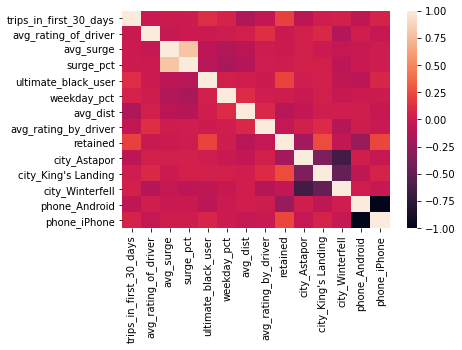

In [14]:
sns.heatmap(data_clean.corr())

From the above heatmap it is clear that the phone variables are perfectly inversely correlated and one should be dropped. The city variables are not as correlated and all 3 can remain in the model.

In [15]:
data_clean.drop('phone_Android',axis=1,inplace=True)

Create X and y variables:

In [16]:
X = data_clean.drop(['signup_date','last_trip_date','retained'],axis=1)
y = data_clean['retained']

Scale the X data and split X and y into training and test sets:

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=42)

Begin building models:

In [19]:
lr = LogisticRegression()
reg = lr.fit(X_train,y_train)
reg.score(X_test,y_test)

0.708936498745416

In [20]:
confusion_matrix(y_test, reg.predict(X_test))

array([[4989, 1083],
       [1933, 2357]], dtype=int64)

In [21]:
print("The log reg model precision is",round(precision_score(y_test, reg.predict(X_test)),2),"and the recall is", round(recall_score(y_test, reg.predict(X_test)),2))

The log reg model precision is 0.69 and the recall is 0.55


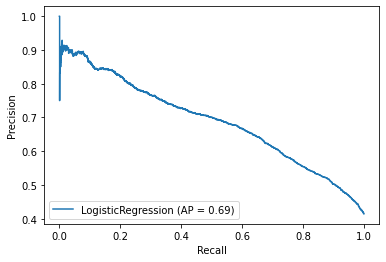

In [22]:
plot_precision_recall_curve(reg,X_test,y_test)

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7303609341825902

In [24]:
confusion_matrix(y_test, knn.predict(X_test))

array([[4732, 1340],
       [1454, 2836]], dtype=int64)

In [25]:
print("The knn model precision is",round(precision_score(y_test, knn.predict(X_test)),2),"and the recall is", round(recall_score(y_test, knn.predict(X_test)),2))

The knn model precision is 0.68 and the recall is 0.66


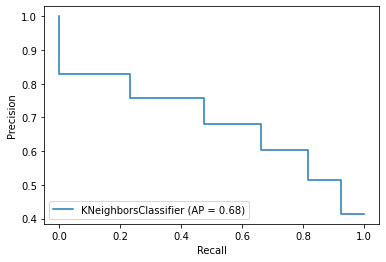

In [26]:
plot_precision_recall_curve(knn,X_test,y_test)

Inspect coefficient values for logistic regression model to try and pull insights:

In [27]:
coefficients = pd.DataFrame({'feature':X.columns.values,'coeff':list(reg.coef_[0])})
coefficients.sort_values('coeff',ascending = False)

,feature,coeff
11,phone_iPhone,0.489200
4,ultimate_black_user,0.445987
9,city_King's Landing,0.430495
0,trips_in_first_30_days,0.427249
3,surge_pct,0.086804
5,weekday_pct,-0.005679
1,avg_rating_of_driver,-0.027796
2,avg_surge,-0.058409
10,city_Winterfell,-0.065736
7,avg_rating_by_driver,-0.085428


# Ultimate Challenge Answers

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?  

37.61%

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?Include any key indicators of model performance.  

I built two models to determine user retention. I used the features shown in the table above and scaled them before building any models. The first model was a logistic regression model that had 70.9% accuracy, 0.69 precision and 0.55 recall. The second model was a K-nearest neighbors model that had 73.0% accuracy, 0.68 precision and 0.66 recall. Both models could definitely be improved with some hyperparameter tuning as the models used were simply out-of-the-box. While the K-nearest neighbors model performed better, it is less useful for determining which features are the most beneficial and which are the most detrimental to user retention. Therefore the coefficients of the logistiv regression model were used to pull valuable insights.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

Ultimate can use the feature coefficients from the logistic regression model to determine the most and least beneficial features for user retention. The coefficients with negative values are detrimental and those with positive values are beneficial. For example, the top coefficient is the Iphone feature, meaning Iphone users are much more likely to be retained. This could suggest that the Android app is not as optimized and is leading to less retention among Android users. Next Ultimate could look at the coefficients for the 3 cities. It is clear that King's landing residents are much more likely to be retained and those from Astapor are much less likely. Perhaps Ultimate should consider looking into what reasons Astaporians are not being retained. The other coefficients can be thought about similarly and used to make changes that would hopefully increase retention.
